In [1]:
#Import packages and set variables

import numpy as np
import h5py
import pkg_resources
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../')

%matplotlib inline
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = 6,4
plt.rcParams.update({'font.size': 16})
plt.rcParams['image.aspect'] = 'equal'
plt.rcParams['image.cmap'] = 'seismic'

import ActflowToolbox as actflow

actflow_example_dir = pkg_resources.resource_filename('ActflowToolbox.examples', 'HCP_example_data/')

networkpartition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
networkdef = np.loadtxt(networkpartition_dir + '/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]
orderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)


subjNums = ['100206','108020','117930','126325','133928','143224','153934','164636','174437',
            '183034','194443','204521','212823','268749','322224','385450','463040','529953',
            '587664','656253','731140','814548','877269','978578','100408','108222','118124',
            '126426','134021','144832']
numsubjs=np.shape(subjNums)[0]
numnodes=360
numtimepoints=1195

taskConditions = ['EMOTION:fear','EMOTION:neut','GAMBLING:win','GAMBLING:loss','LANGUAGE:story','LANGUAGE:math',
                  'MOTOR:cue','MOTOR:lf','MOTOR:rf','MOTOR:lh','MOTOR:rh','MOTOR:t','REASONING:rel',
                  'REASONING:match','SOCIAL:mental','SOCIAL:rnd','WM 0bk:body','WM 0bk:faces','WM 0bk:places',
                  'WM 0bk:tools','WM 2bk:body','WM 2bk:faces','WM 2bk:places','WM 2bk:tools']


## Cole-Anticevic Network Partition
### Used for this example
![Cole-Anticevic Network Partition](../images/CABNP_cortex.png)

In [2]:
#Load data
#Preprocessed as described here: https://doi.org/10.1101/560730

#Load resting-state fMRI data; 30 HCP subjects, one run of resting-state fMRI each
restdata=np.zeros((numnodes,numtimepoints,numsubjs))
scount = 0
for subj in subjNums:
    file_path=actflow_example_dir + 'HCP_example_restrun1_subj' + subj + '_data' + '.h5'
    h5f = h5py.File(file_path,'r')
    dataid = 'restdata'
    restdata[:,:,scount] = h5f[dataid][:]
    h5f.close()
    scount += 1

#Load task GLM activations; 30 HCP subjects, 24 task conditions
file_path=actflow_example_dir + 'HCP_example_taskactivations_data' + '.h5'
h5f = h5py.File(file_path,'r')
dataid = 'taskbeta'
activations_bycond = h5f[dataid][:]
h5f.close()


In [3]:
#Run activity flow mapping with Pearson correlation FC
restFC_corr=np.zeros((numnodes,numnodes,numsubjs))
scount=0
for subj in subjNums:
    restFC_corr[:,:,scount]=actflow.connectivity_estimation.corrcoefconn(restdata[:,:,scount])
    scount += 1
print("==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr, print_by_condition=False)


==Activity flow mapping results, correlation-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.58, t-value vs. 0: 50.09, p-value vs. 0: 1.0236377961735527e-29
 
Mean % variance explained (R^2 score, coeff. of determination) = -747.11
 
Mean MAE (mean absolute error) = 313.77
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scik

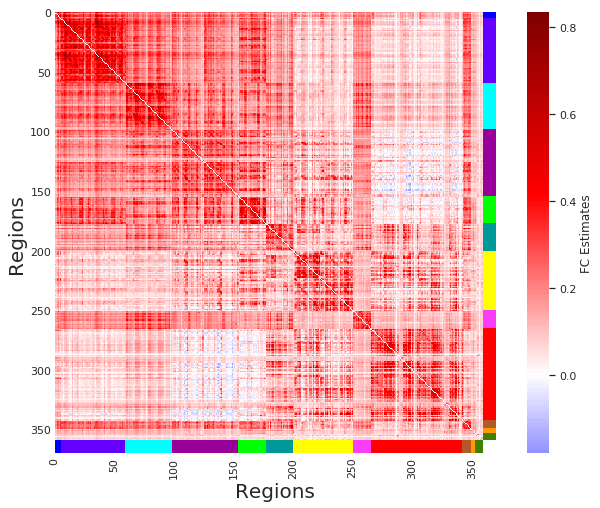

In [4]:
#Visualize FC matrix
fcmat=np.mean(restFC_corr[netorder,:,:][:,netorder,:],axis=2)
actflow.tools.addNetColors_Seaborn(fcmat)

[Text(39.5, 0.5, 'Regions')]

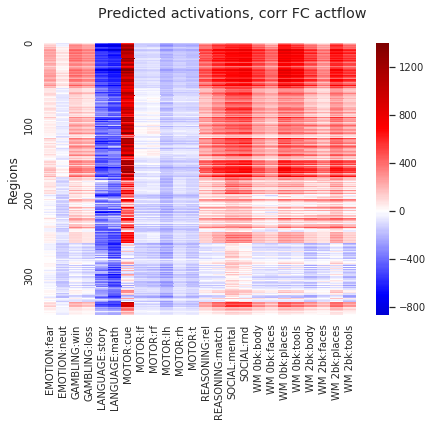

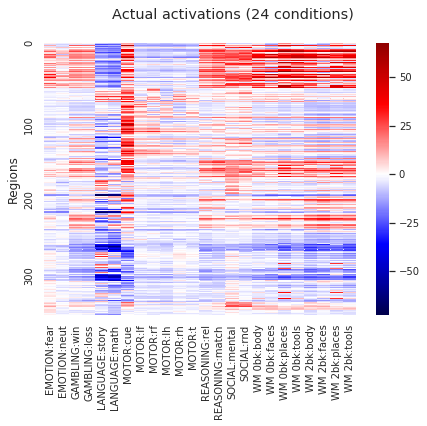

In [5]:
#Visualize predicted and actual activation patterns
plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, corr FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')

#Save figure to file
# fig.savefig('restActflowPred_CorrFC.pdf')


In [6]:
%%time
#Run activity flow mapping with ten subjects (to reduce processing time)
restFC_mreg=np.zeros((numnodes,numnodes,numsubjs))
for scount in np.arange(numsubjs):
    restFC_mreg[:,:,scount]=actflow.connectivity_estimation.multregconn(restdata[:,:,scount])
print("==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==")
actflowOutput_restFCMReg_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_mreg, print_by_condition=False)


==Activity flow mapping results, multiple-regression-based resting-state FC, 24 task conditions==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 30 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = 0.78, t-value vs. 0: 62.27, p-value vs. 0: 1.9635597302245892e-32
 
Mean % variance explained (R^2 score, coeff. of determination) = 0.57
 
Mean MAE (mean absolute error) = 7.54
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://s

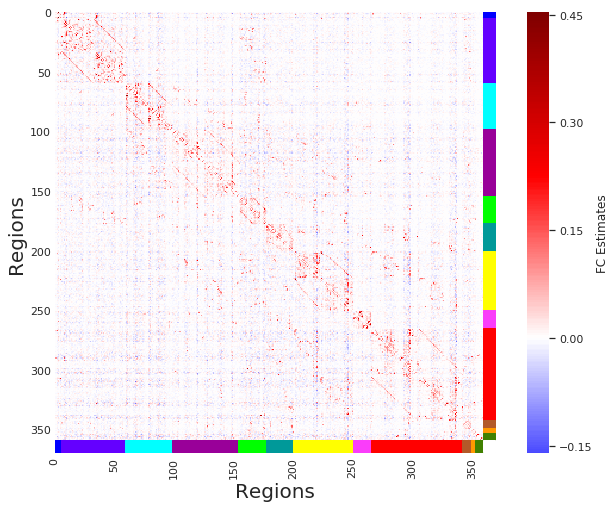

In [7]:
#Visualize multreg FC matrix
# ax = sns.heatmap(np.mean(restFC_mreg[netorder,:,:][:,netorder,:],axis=2),square=True,center=0,cmap='seismic',cbar=True,xticklabels=50,yticklabels=50)
# ax.figure.suptitle('Resting-state multiple-regression FC')
# ax.set(xlabel='Regions',ylabel='Regions')
fcmat=np.mean(restFC_mreg[netorder,:,:][:,netorder,:],axis=2)
actflow.tools.addNetColors_Seaborn(fcmat)

[Text(39.5, 0.5, 'Regions')]

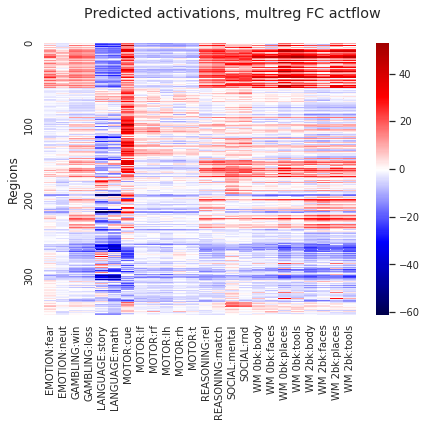

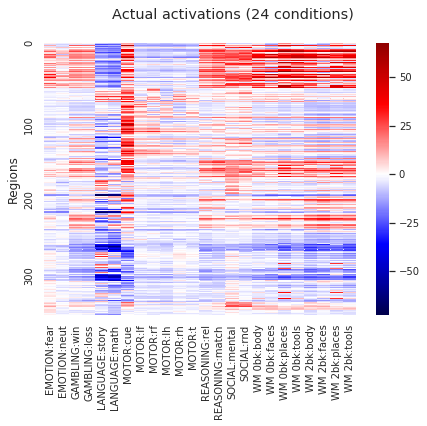

In [8]:
#Visualize predicted and actual activation patterns, with multiple-regression FC
plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Predicted activations, multreg FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=taskConditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')


In [9]:
print("===Compare resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===")
model_compare_RestMultRegFCVsRestCorrFC_Actflow = actflow.model_compare(target_actvect=actflowOutput_restFCCorr_bycond['actVect_actual_group'][:,:,0:10], model1_actvect=actflowOutput_restFCMReg_bycond['actPredVector_bytask_bysubj'], model2_actvect=actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'][:,:,0:10], full_report=True, print_report=True, print_by_condition=False)


===Compare resting-state multregFC actflow predictions to resting-state corrFC actflow prediction, 10 subjects only===
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 24 conditions across 360 nodes, p-values based on 10 subjects (cross-subject variance in comparisons)
 
Model1 mean Pearson r=0.78
Model2 mean Pearson r=0.59
R-value difference = 0.20
Model1 vs. Model2 T-value: 12.81, p-value: 4.4133474737407104e-07
 
Model1 mean % predicted variance explained R^2=0.58
Model2 mean % predicted variance explained R^2=-595.00
R^2 difference = 595.57
 
Model1 mean MAE = 7.08
Model2 mean MAE = 277.10
Model1 vs. Model2 mean MAE difference = -270.02
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R